<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Bidirectional_RNN_IMDb_ReviewTokoBaju_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


#IMDb

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
import nltk
import os

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# ==================== GPU SETUP ====================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# ==================== SET SEED & CONFIG ====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 64
EPOCHS = 10
EPOCHS_TUNER = 4
validation_split = 0.2
MAX_FEATURES = 15000
MAX_LENGTH = 200

# ==================== PREPROCESSING ====================
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

In [5]:
# ==================== BUILD MODEL ====================
def build_model_hyperband(hp, max_features, max_length):
    from tensorflow.keras import regularizers

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=8)
    ))

    units = hp.Int('BiRNN_units', 4, 128, step=4)
    model.add(Bidirectional(LSTM(units=units, kernel_regularizer=regularizers.l2(0.001))))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dropout(hp.Float('BiRNN_dropout', 0.5, 0.8, step=0.1)))
    model.add(Dense(units * 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
# ==================== EVALUASI & VISUALISASI ====================
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Plot Accuracy & Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

    # Simpan ke global results
    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

In [7]:
# ==================== PERSIAPAN DATASET ====================
def process_IMDB_dataset():
    from tensorflow.keras.datasets import imdb

    # Load the IMDb dataset
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

    # Pad the sequences to the same length
    X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
    X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 00m 41s]
val_accuracy: 0.5062000155448914

Best val_accuracy So Far: 0.8691999912261963
Total elapsed time: 00h 05m 24s

Best Hyperparameters:
embedding_dim: 48
BiRNN_units: 16
BiRNN_dropout: 0.7
learning_rate: 0.0027270523369315545
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5780 - loss: 0.7608 - val_accuracy: 0.8008 - val_loss: 0.4981
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8247 - loss: 0.4668 - val_accuracy: 0.8532 - val_loss: 0.4386
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.8841 - loss: 0.3334 - val_accuracy: 0.8370 - val_loss: 0.4398
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9152 - loss: 0.2594 - val_accuracy: 0.8490 - val_loss: 0.5415
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9277 - loss: 0.2354 - val_accuracy: 0.8452 - val_loss: 0.4640
Ep

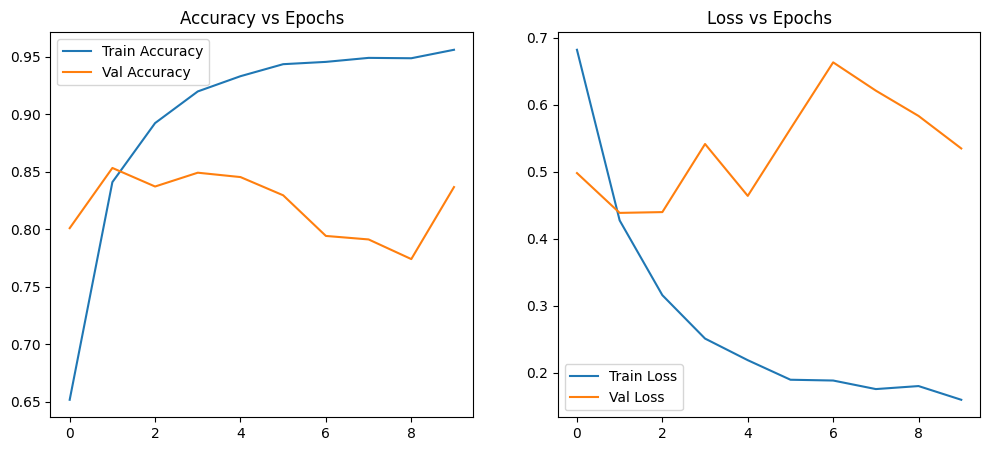

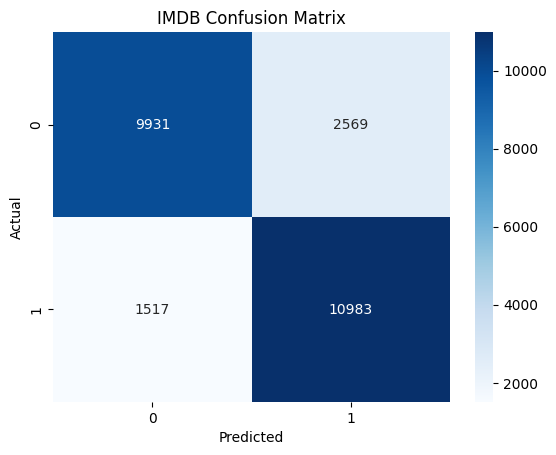

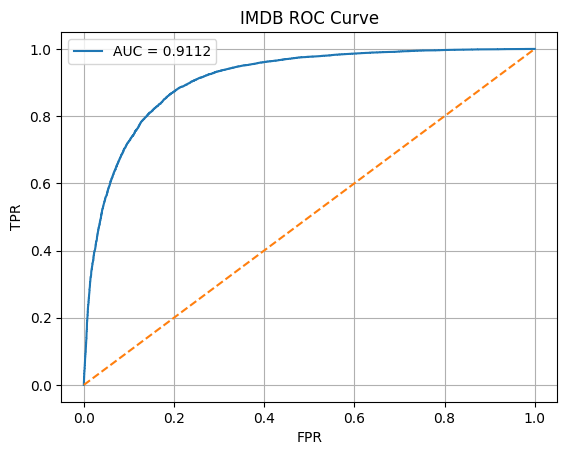

In [8]:
# ==================== EKSEKUSI ====================
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=None,  # Prevent saving tuner results to disk
        project_name=dataset_name
    )

    # Tidak menggunakan max_trials, Hyperband akan mengelola trial secara internal
    tuner.search(X_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name)

    return model, results

# ==================== RUN ====================
model, results = run_experiment("IMDB", process_IMDB_dataset, MAX_FEATURES, MAX_LENGTH)

#Review Toko Baju

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from collections import Counter
import nltk
import os

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# ==================== GPU SETUP ====================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# ==================== SET SEED & CONFIG ====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 64
EPOCHS = 4
EPOCHS_TUNER = 4
validation_split = 0.2
MAX_FEATURES = 15000
MAX_LENGTH = 200

# ==================== PREPROCESSING ====================
def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

In [11]:
# ==================== BUILD MODEL ====================
def build_model_hyperband(hp, max_features, max_length):
    from tensorflow.keras import regularizers

    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', 8, 256, step=8)
    ))

    units = hp.Int('BiRNN_units', 4, 128, step=4)
    model.add(Bidirectional(LSTM(units=units, kernel_regularizer=regularizers.l2(0.001))))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dropout(hp.Float('BiRNN_dropout', 0.5, 0.8, step=0.1)))
    model.add(Dense(units * 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
# ==================== EVALUASI & VISUALISASI ====================
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Plot Accuracy & Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.8233507871627808

Best val_accuracy So Far: 0.8810378313064575
Total elapsed time: 00h 04m 03s

Best Hyperparameters:
embedding_dim: 40
BiRNN_units: 40
BiRNN_dropout: 0.5
learning_rate: 0.0009133135615318786
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/4
283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8216 - loss: 0.5864 - val_accuracy: 0.8691 - val_loss: 0.3634
Epoch 2/4
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8940 - loss: 0.3191 - val_accuracy: 0.8329 - val_loss: 0.4038
Epoch 3/4
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9162 - loss: 0.2598 - val_accuracy: 0.8810 - val_loss: 0.3963
Epoch 4/4
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9351 - loss: 0.2081 - val_accuracy: 0.8819 - val_loss: 0.4810
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Final Evaluation on ReviewTokoBaju Test Set:
Accuracy : 0.8819
Precision: 0.9084
Recall   : 0.9521
F1 Score : 0.9297


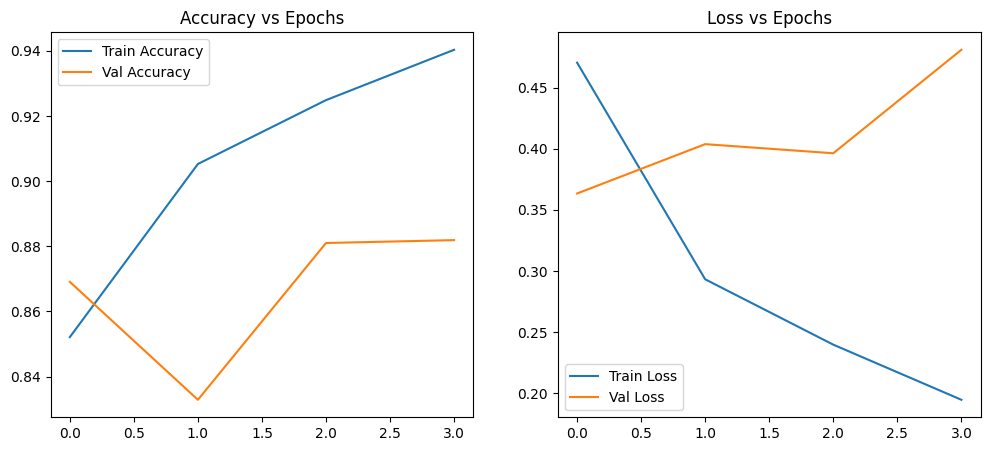

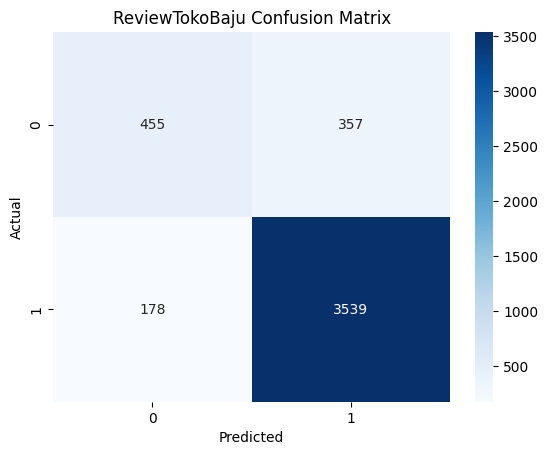

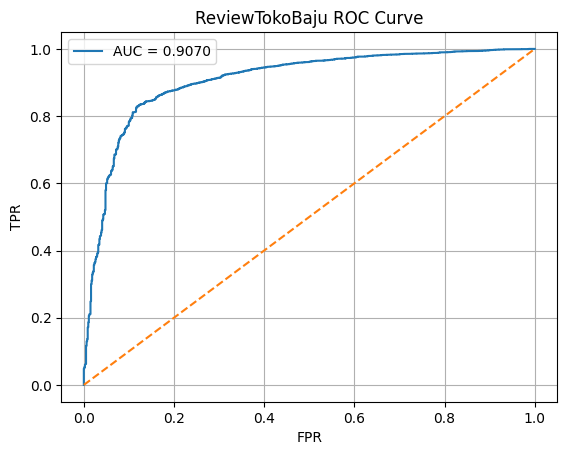

In [13]:
# ==================== PERSIAPAN DATASET ====================
def process_ReviewTokoBaju_dataset():
    file_path = "/content/drive/MyDrive/Deep Learning/ReviewTokoBaju.csv"
    df = pd.read_csv(file_path)

    df = df.drop_duplicates()
    df = df[['Review Text', 'Recommended IND']].dropna()
    df['label'] = df['Recommended IND'].astype(int)

    texts = df['Review Text'].astype(str).tolist()
    labels = df['label'].tolist()

    X, y, tokenizer = preprocess_text_data(texts, labels, MAX_FEATURES, MAX_LENGTH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    return X_train, y_train, X_test, y_test

# ==================== EKSEKUSI ====================
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name}',
        project_name=dataset_name
    )

    # Tidak menggunakan max_trials, Hyperband akan mengelola trial secara internal
    tuner.search(X_train, y_train,
                 epochs=EPOCHS_TUNER,
                 batch_size=BATCH_SIZE,
                 validation_split=validation_split)

    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for k, v in best_hps.values.items():
        print(f"{k}: {v}")

    model = tuner.hypermodel.build(best_hps)
    results = evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name)

    return model, results

# ==================== RUN ====================
model, results = run_experiment("ReviewTokoBaju", process_ReviewTokoBaju_dataset, MAX_FEATURES, MAX_LENGTH)


#Deteksi Sarkasme

In [14]:
# ===== Import Libraries =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, LayerNormalization  # <== GRU di sini
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from keras_tuner import Hyperband
from tensorflow.keras import regularizers

# ===== Download NLTK data =====
nltk.download('stopwords')
nltk.download('punkt')

# ===== TensorFlow GPU Configuration =====
tf.keras.mixed_precision.set_global_policy('mixed_float16')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# ===== Seed Initialization =====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===== Global Variables =====
BATCH_SIZE = 64
EPOCHS = 5
EPOCHS_TUNER = 4
validation_split = 0.2

# ===== Helper Functions =====

def preprocess_text_data(texts, labels, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

def build_model_hyperband(hp, max_features, max_length):
    model = Sequential()
    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', min_value=8, max_value=256, step=8)
    ))
    model.add(Bidirectional(tf.keras.layers.GRU(
        units=hp.Int('BiRNN_units', min_value=32, max_value=128, step=32),
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        reset_after=True,
        return_sequences=False,
        dropout=hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1),
        recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(0.001)
    )))
    model.add(LayerNormalization())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation="relu"))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.4, max_value=0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ===== Visualization =====
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{dataset_name} - Accuracy vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{dataset_name} - Loss vs Epochs')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    class_labels = ['Not Sarcastic', 'Sarcastic']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{dataset_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

    return {
        "Dataset": dataset_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

In [17]:
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    print(f"\n{'='*20} Running {dataset_name} Experiment {'='*20}")

    X_train, y_train, X_test, y_test = prepare_data_fn()

    tuner = Hyperband(
        lambda hp: build_model_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        overwrite=True  # Ensure no results are saved to disk
    )

    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        X_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    best_model = tuner.hypermodel.build(best_hps)

    results = evaluate_and_visualize(
        best_model, X_train, y_train, X_test, y_test,
        dataset_name
    )

    return best_model, results

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.6881141662597656

Best val_accuracy So Far: 0.850959300994873
Total elapsed time: 00h 02m 35s

Best Hyperparameters:
embedding_dim: 64
BiRNN_units: 32
dropout: 0.3
dense_units: 256
dropout_dense: 0.4
learning_rate: 0.0038175060418429835
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7160 - loss: 0.5859 - val_accuracy: 0.8572 - val_loss: 0.3470
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9112 - loss: 0.2493 - val_accuracy: 0.8467 - val_loss: 0.4358
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9561 - loss: 0.1409 - val_accuracy: 0.8300 - val_loss: 0.5201
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9688 - loss: 0.1050 - val_accuracy: 0.8285 - val_loss: 0.6328
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9765 - loss: 0.0884 - val_accuracy: 0.8317 - val_loss: 0.6712
167/

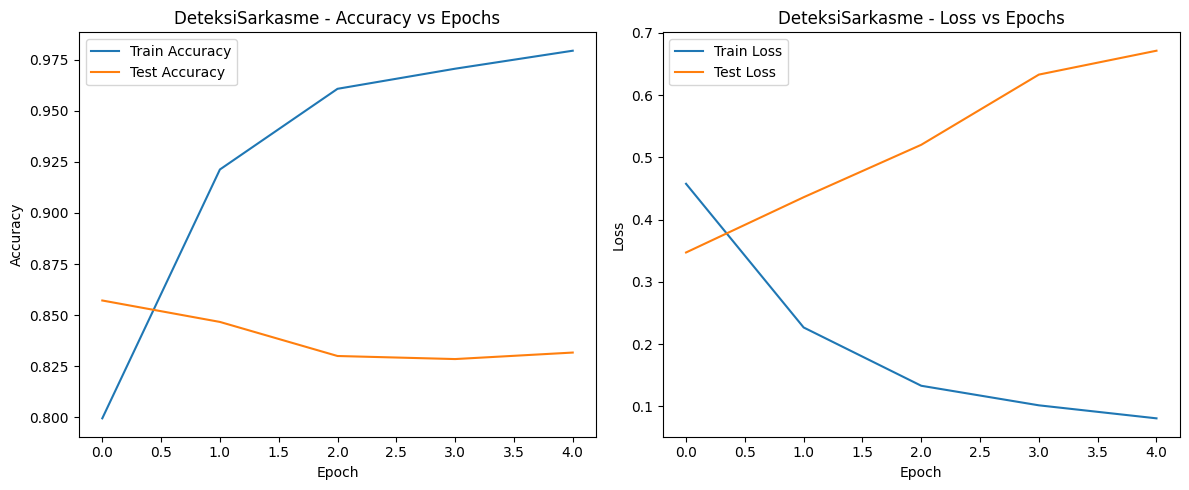

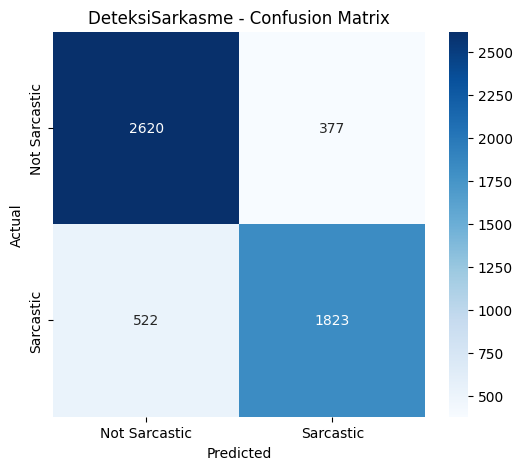

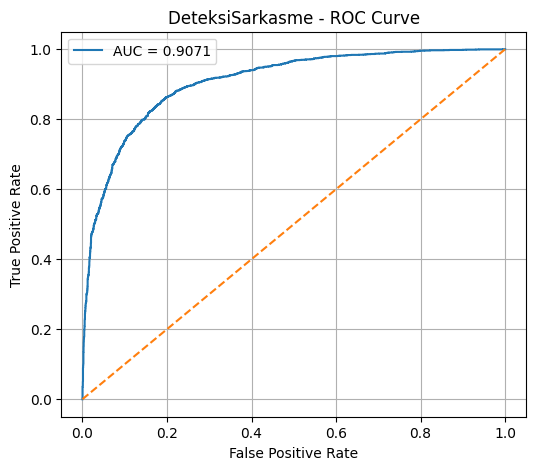

In [18]:
# ===== Dataset Specific Processing =====

MAX_FEATURES_DeteksiSarkasme = 10000
MAX_LENGTH_DeteksiSarkasme = 35

def process_DeteksiSarkasme_dataset():
    print("\n=== Processing DeteksiSarkasme Dataset ===")
    deteksisarkasme_file = "/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json"

    with open(deteksisarkasme_file, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df.drop_duplicates()

    # Preprocessing function
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['headline'] = df['headline'].apply(preprocess_text)

    X, y, tokenizer = preprocess_text_data(
        df['headline'].tolist(),
        df['is_sarcastic'].tolist(),
        MAX_FEATURES_DeteksiSarkasme,
        MAX_LENGTH_DeteksiSarkasme
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    return X_train, y_train, X_test, y_test

# ===== Main Execution =====

if __name__ == "__main__":
    results = {}
    model, res = run_experiment("DeteksiSarkasme", process_DeteksiSarkasme_dataset,
                                MAX_FEATURES_DeteksiSarkasme, MAX_LENGTH_DeteksiSarkasme)
    results["DeteksiSarkasme"] = res


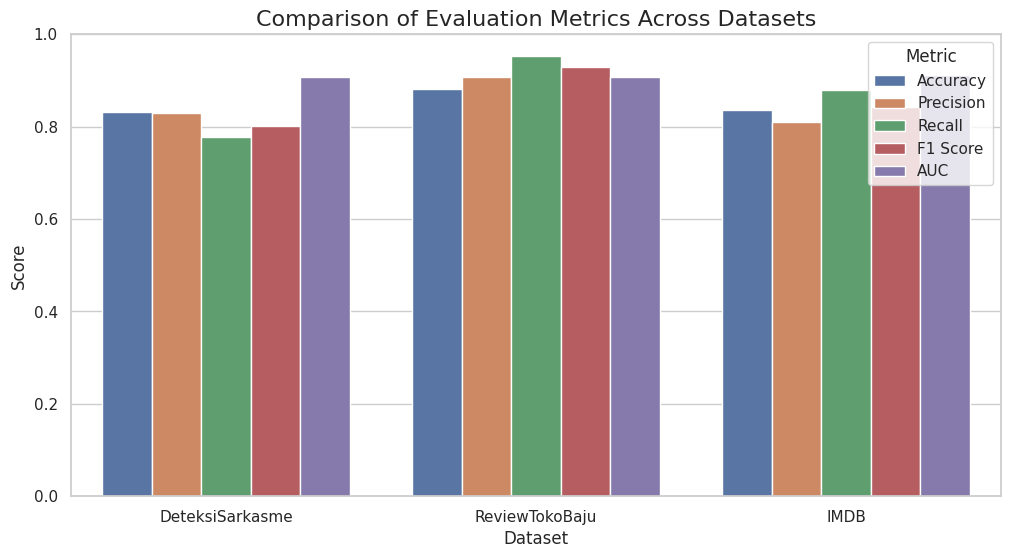

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data hasil evaluasi
data = {
    'Dataset': ['DeteksiSarkasme', 'ReviewTokoBaju', 'IMDB'],
    'Accuracy': [0.8317, 0.8819, 0.8366],
    'Precision': [0.8286, 0.9084, 0.8104],
    'Recall': [0.7774, 0.9521, 0.8786],
    'F1 Score': [0.8022, 0.9297, 0.8432],
    'AUC': [0.9071, 0.9070, 0.9112]
}

# Membuat DataFrame
df_results = pd.DataFrame(data)

# Bikin dataframe untuk plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
df_plot = df_results.melt(id_vars=['Dataset'], value_vars=metrics, var_name='Metric', value_name='Score')

# Membuat plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Score', hue='Metric', data=df_plot)

plt.title('Comparison of Evaluation Metrics Across Datasets', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()
